In [1]:
from IPython.core.display import HTML
with open ("../style.css", "r") as file:
    css = file.read()
HTML(css)

# A Simple Compiler for a Fragment of `C`

This file shows how a simple compiler for a fragment of the programming language `C` can be implemented using `Ply`.

## Specification of the Scanner

The scanner that we implement here is similar to the scanner that we had used for our symbolic calculator.

In [2]:
import ply.lex as lex

In [3]:
tokens = [ 'NUMBER', 'ID', 'EQ', 'NE', 'LE', 'GE', 'AND', 'OR',
           'INT', 'IF', 'ELSE', 'WHILE', 'RETURN'
         ]

The token `Number` specifies a fully featured *floating point number*.

In [4]:
def t_NUMBER(t):
    r'0|[1-9][0-9]*(\.[0-9]+)?(e[+-]?([1-9][0-9]*))?'
    t.value = t.value
    return t

Below, we define the tokens for operator symbols consisting of more than one character.

In [5]:
def t_EQ(t):
    r'=='
    return t

def t_NE(t):
    r'!='
    return t

def t_LE(t):
    r'<='
    return t

def t_GE(t):
    r'>='
    return t

def t_AND(t):
    r'&&'
    return t

def t_OR(t):
    r'\|\|'
    return t

def t_COMMENT(t):
    r'//[^\n]*'
    pass

The keywords `'int', 'if', 'else', 'while', 'return'` have to be dealt with separately as they are syntactical identical to identifiers.

In [6]:
keywords = { 'int'   : 'INT', 
             'if'    : 'IF',
             'else'  : 'ELSE', 
             'while' : 'WHILE', 
             'return': 'RETURN'
           }

In [7]:
def t_ID(t):
    r'[a-zA-Z][a-zA-Z0-9_]*'
    t.type = keywords.get(t.value, 'ID')
    return t

In [8]:
literals = ['+', '-', '*', '/', '(', ')', '{', '}', ';', '=', '<', '>', '!']

In [9]:
t_ignore  = ' \t\r'

In [10]:
def t_newline(t):
    r'\n+'
    t.lexer.lineno += t.value.count('\n')

In [11]:
def t_error(t):
    print(f"Illegal character '{t.value[0]}'")
    t.lexer.skip(1)

In [12]:
__file__ = 'main'

In [13]:
lexer = lex.lex()

## Specification of the Parser

We will use the following grammar to specify the language that our compiler can translate:
```
program
    : function
    | function program

function 
    : INT ID '(' param_list ')' '{' decl_list stmnt_list '}'

param_list 
    : 
    | INT ID 
    | INT ID ',' ne_param_list

ne_param_list
    : INT ID
    | INT ID ',' ne_param_list
    
decl_list
    : INT ID ';'
    | INT ID ';' decl_list

stmnt_list
    : stmnt ';'
    | stmnt ';' stmnt_list
    
stmnt 
    : '{' stmnt_list '}' 
    | ID '=' expr    
    | IF '(' bool_expr ')' stmnt                 
    | IF '(' bool_expr ')' stmnt ELSE stmnt
    | WHILE '(' bool_expr ')' stmnt
    | RETURN expr    
    | expr           

expr: expr '+'  expr                 
    | expr '-' expr               
    | expr '*' expr               
    | expr '/' expr               
    | '(' expr ')' 
    | NUMBER
    | ID                      
    | ID '(' expr_list ')'       

expr_list
    : 
    | expr
    | expr ',' ne_expr_list

ne_expr_list
    : expr
    | expr ',' ne_expr_list

bool_expr 
    : expr '==' expr     
    | expr '!=' expr     
    | expr '<=' expr     
    | expr '>=' expr     
    | expr '<'  expr      
    | expr '>'  expr     
    | '!' bool_expr            
    | bool_expr '&&' bool_expr 
    | bool_expr '||' bool_expr  
```
We will use precedence declarations to resolve the ambiguity that is inherent in this grammar.

In [14]:
import ply.yacc as yacc

The *start variable* of our grammar is `program`.

In [15]:
start = 'program'

In [16]:
precedence = (
    ('left', 'OR'),
    ('left', 'AND'),
    ('left', '!'),
    ('nonassoc', 'EQ', 'NE', 'LE', 'GE', '<', '>'),
    ('left', '+', '-'),
    ('left', '*', '/')
)

In [17]:
def p_program_one(p):
    "program : function"
    p[0] = ('program', p[1])
    
def p_program_more(p):
    "program : function program"
    p[0] = ('program', p[1]) + p[2][1:]

In [18]:
def p_function(p):
    "function : INT ID '(' param_list ')' '{' decl_list stmnt_list '}'"
    p[0] = ('fct', p[2], p[4], p[7], p[8])

In [19]:
def p_param_list_empty(p):
    "param_list :"
    p[0] = ('.', )
    
def p_param_list_one(p):
    "param_list : INT ID"
    p[0] = ('.', p[2])
    
def p_param_list_more(p):
    "param_list : INT ID ',' ne_param_list"
    p[0] = ('.', p[2]) + p[4][1:]

def p_ne_param_list_one(p):
    "ne_param_list : INT ID"
    p[0] = ('.', p[2])
    
def p_ne_param_list_more(p):
    "ne_param_list : INT ID ',' ne_param_list"
    p[0] = ('.', p[2]) + p[4][1:]

In [20]:
def p_decl_list_one(p):
    "decl_list : INT ID ';'"
    p[0] = ('.', p[2])

def p_decl_list_more(p):
    "decl_list : INT ID ';' decl_list"
    p[0] = ('.', p[2]) + p[4][1:]

In [21]:
def p_stmnt_list_one(p):
    "stmnt_list : stmnt ';'"
    p[0] = ('.', p[1])

def p_stmnt_list_more(p):
    "stmnt_list : stmnt ';' stmnt_list"
    p[0] = ('.', p[1]) + p[3][1:]

In [22]:
def p_stmnt_block(p):
    "stmnt : '{' stmnt_list '}'"
    p[0] = p[2]
    
def p_stmnt_assign(p):
    "stmnt : ID '=' expr"
    p[0] = ('=', p[1], p[3])
    
def p_stmnt_if(p):
    "stmnt : IF '(' bool_expr ')' stmnt"
    p[0] = ('if', p[3], p[5])   
    
def p_stmnt_if_else(p):
    "stmnt : IF '(' bool_expr ')' stmnt ELSE stmnt"
    p[0] = ('if-else', p[3], p[5], p[7])
    
def p_stmnt_while(p):
    "stmnt : WHILE '(' bool_expr ')' stmnt"
    p[0] = ('while', p[3], p[5])
    
def p_stmnt_return(p):
    "stmnt : RETURN expr"
    p[0] = ('return', p[2])
    
def p_stmnt_expr(p):
    "stmnt : expr"
    p[0] = p[1]

In [23]:
def p_bool_expr_eq(p):
    "bool_expr : expr EQ expr"
    p[0] = ('==', p[1], p[3])

def p_bool_expr_ne(p):
    "bool_expr : expr NE expr"
    p[0] = ('!=', p[1], p[3])

def p_bool_expr_le(p):
    "bool_expr : expr LE expr"
    p[0] = ('<=', p[1], p[3])
    
def p_bool_expr_ge(p):
    "bool_expr : expr GE expr"
    p[0] = ('>=', p[1], p[3])
    
def p_bool_expr_lt(p):
    "bool_expr : expr '<' expr"
    p[0] = ('<', p[1], p[3])

def p_bool_expr_gt(p):
    "bool_expr : expr '>' expr"
    p[0] = ('>', p[1], p[3])
    
def p_bool_expr_neg(p):
    "bool_expr : '!' expr"
    p[0] = ('!', p[2])
    
def p_bool_expr_and(p):
    "bool_expr : expr AND expr"
    p[0] = ('&&', p[1], p[3])
    
def p_bool_expr_or(p):
    "bool_expr : expr OR expr"
    p[0] = ('||', p[1], p[3])

In [24]:
def p_expr_plus(p):
    "expr : expr '+' expr"
    p[0] = ('+', p[1], p[3])
    
def p_expr_minus(p):
    "expr : expr '-' expr"
    p[0] = ('-', p[1], p[3])
    
def p_expr_times(p):
    "expr : expr '*' expr"
    p[0] = ('*', p[1], p[3])
    
def p_expr_divide(p):
    "expr : expr '/' expr"
    p[0] = ('/', p[1], p[3])
    
def p_expr_group(p):
    "expr : '(' expr ')'"
    p[0] = p[2]

def p_expr_number(p):
    "expr : NUMBER"
    p[0] = ('number', p[1])

def p_expr_id(p):
    "expr : ID"
    p[0] = p[1]
    
def p_expr_fct_call(p):
    "expr : ID '(' expr_list ')'"
    p[0] = ('call', p[1]) + p[3][1:]
    
def p_expr_list_empty(p):
    "expr_list :"
    p[0] = ('.',)
    
def p_expr_list_one(p):
    "expr_list : expr"
    p[0] = ('.', p[1])     

def p_expr_list_more(p):
    "expr_list : expr ',' ne_expr_list"
    p[0] = ('.', p[1]) + p[3][1:]     

def p_ne_expr_list_one(p):
    "ne_expr_list : expr"
    p[0] = ('.', p[1]) 
    
def p_ne_expr_list_more(p):
    "ne_expr_list : expr ',' ne_expr_list"
    p[0] = ('.', p[1]) + p[3][1:] 

In [25]:
def p_error(p):
    if p:
        print(f'Syntax error at {p.value} in line {p.lexer.lineno}, character {p.lexpos}')
    else:
        print('Syntax error at end of input.')

Setting the optional argument `write_tables` to `False` <B style="color:red">is required</B> to prevent an *obscure bug* where the parser generator tries to read an empty parse table.

In [26]:
parser = yacc.yacc(write_tables=False, debug=True)

Generating LALR tables


Let's look at the action table that is generated.

In [27]:
!cat parser.out

Created by PLY version 3.11 (http://www.dabeaz.com/ply)

Grammar

Rule 0     S' -> program
Rule 1     bool_expr -> expr EQ expr
Rule 2     decl_list -> INT ID ;
Rule 3     expr -> expr + expr
Rule 4     function -> INT ID ( param_list ) { decl_list stmnt_list }
Rule 5     param_list -> <empty>
Rule 6     program -> function
Rule 7     stmnt -> { stmnt_list }
Rule 8     stmnt_list -> stmnt ;
Rule 9     bool_expr -> expr NE expr
Rule 10    decl_list -> INT ID ; decl_list
Rule 11    expr -> expr - expr
Rule 12    param_list -> INT ID
Rule 13    program -> function program
Rule 14    stmnt -> ID = expr
Rule 15    stmnt_list -> stmnt ; stmnt_list
Rule 16    bool_expr -> expr LE expr
Rule 17    expr -> expr * expr
Rule 18    param_list -> INT ID , ne_param_list
Rule 19    stmnt -> IF ( bool_expr ) stmnt
Rule 20    bool_expr -> expr GE expr
Rule 21    expr -> expr / expr
Rule 22    ne_param_list -> INT ID
Rule 23    stmnt -> IF ( bool_expr ) stmnt ELSE stmnt
Rule 24    bool_expr -> expr < exp

In [29]:
%run ../ANTLR4-Python/AST-2-Dot.ipynb

In [30]:
def compile(file_name):
    with open(file_name, 'r') as handle:
        program = handle.read() 
    ast = yacc.parse(program)
    return tuple2dot(ast)

In [31]:
!cat Examples/MySum.c

int sum(int n) {
    int s;
    s = 0;
    while (n != 0) {
        s = s + n;
        n = n - 1;    
    };
    return s;
}

int main() {
    int n;
    n = 6 * 6;
    println(sum(n));
}


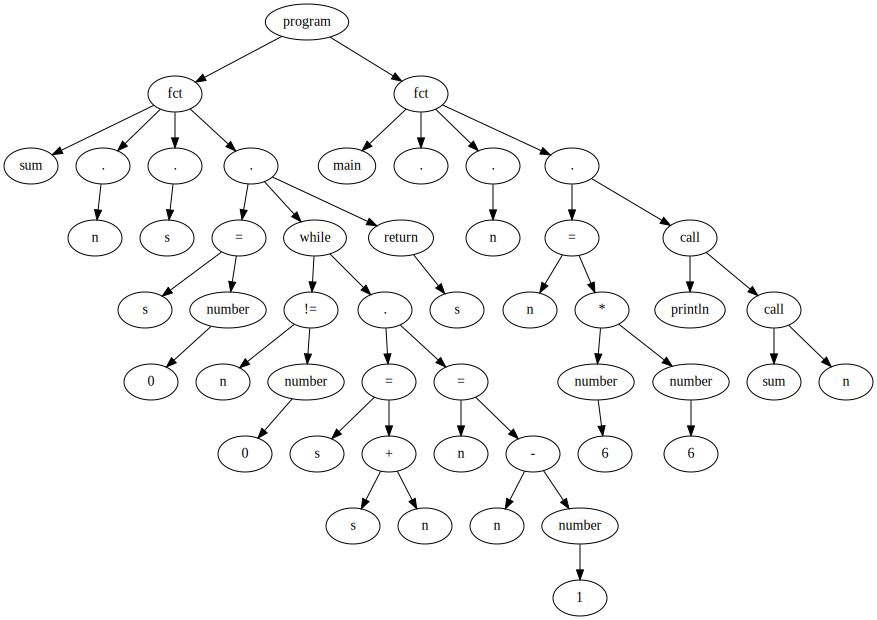

In [32]:
compile('Examples/MySum.c')